# Click-base Lambdas Experiments

## Import necessary modules

In [1]:
import os
os.system("export LC_ALL=en_US.UTF-8")
os.system("export LANG=en_US.UTF-8")

%matplotlib inline

import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

from matplotlib.ticker import MultipleLocator

from ipywidgets import interact, interactive, Dropdown, FloatText, VBox, HBox

from IPython.display import display

# Load the click models for the queries of interest.
# with open('./data/model_query_uniform_lambdas_v1_collection.pkl') as ifile:
# with open('./data/model_query_uniform_lambdas_v2_collection.pkl') as ifile:
with open('./data/model_query_softmax_lambdas_v2_collection.pkl') as ifile:
    MQD = pickle.load(ifile)

# For reproducibility -- re-seed the click models' RNGs.
for click_model_type in MQD:
    for query in MQD[click_model_type]:
        MQD[click_model_type][query]['model'].seed = 42

# Queries Examination

## Available Click Models

In [2]:
MQD.keys()

['DCM', 'CM', 'DBN', 'CCM', 'PBM', 'UBM']

## Available Queries

In [3]:
MQD['CCM'].keys()

['2548',
 '77932',
 '1153',
 '42696',
 '49111',
 '297115',
 '39492',
 '59560',
 '28658',
 '486195']

## Model Query Attractiveness

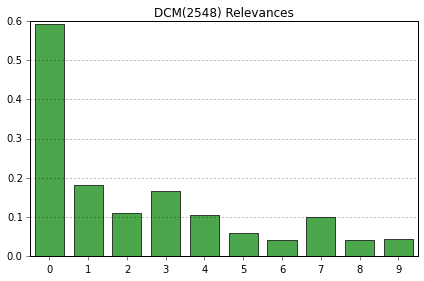

In [4]:
def show_relevances_widget():
    def show_relevances(click_model_type, query):
        relevances = MQD[click_model_type][query]['relevances']

        plt.bar(np.arange(len(relevances)), relevances,
               0.75, alpha=0.7, color='green', align='center')

        plt.title('%s(%s) Relevances' % (click_model_type, query))
        plt.grid(axis='y', which='major')
        plt.gca().xaxis.set_major_locator(MultipleLocator(1.0))
        plt.tick_params(axis='both', which='major', left='on', direction='out',
                       top='off', right='off', bottom='on', labelleft='on',
                       labeltop='off', labelright='off', labelbottom='on')
        plt.xlim([-0.5, len(relevances) - 0.5])
        plt.tight_layout()
        plt.show()

    cmdd = Dropdown(options=MQD.keys(), description='Click Model:')
    qdd = Dropdown(options=MQD['CCM'].keys(), description='Query:')
    
    controls = HBox([cmdd, qdd])
    backend = interactive(show_relevances, click_model_type=cmdd, query=qdd)

    controls.on_displayed(lambda _: show_relevances(cmdd.value, qdd.value))

    display(controls)

show_relevances_widget()

# All Query Documents Attractiveness

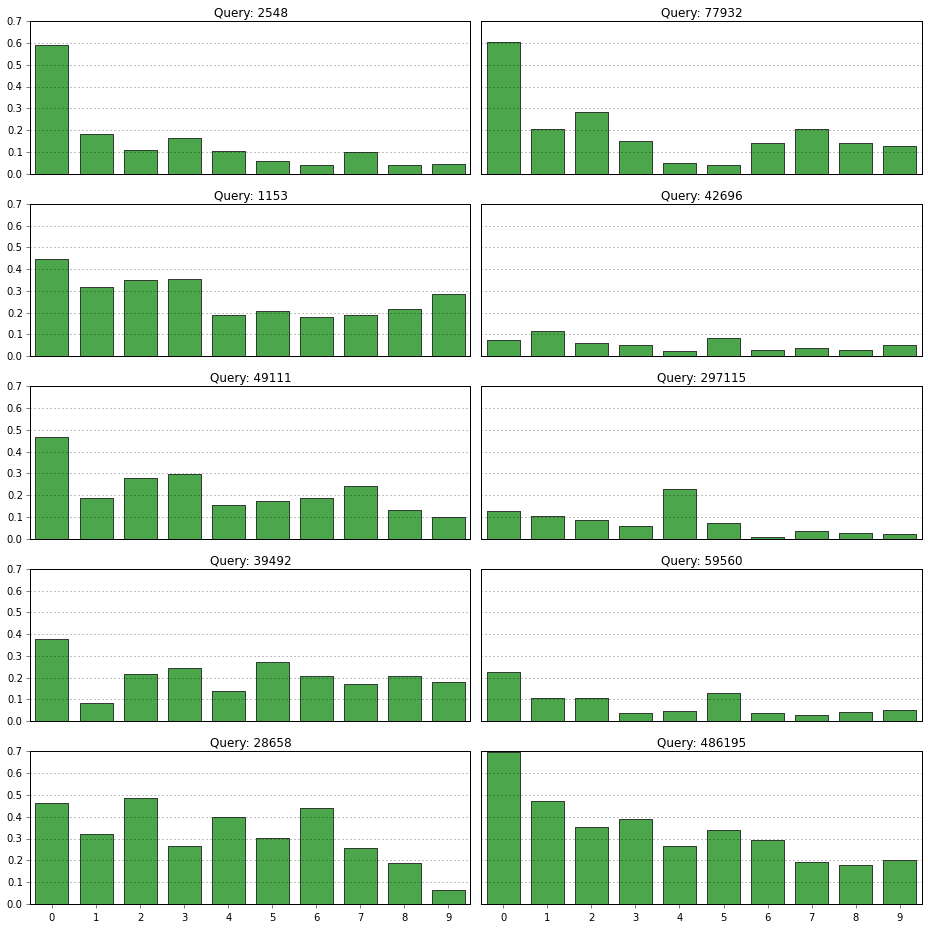

In [5]:
def show_all_queries_relevances(click_model_name):
    fig, axes = plt.subplots(5, 2, figsize=(13, 13), sharex=True, sharey=True)

    for i, query in enumerate(MQD[click_model_name].keys()):
        ax = axes[i / 2, i % 2]

        relevances = MQD[click_model_name][query]['relevances']

        ax.bar(np.arange(len(relevances)), relevances, 0.75,
               alpha=0.7, color='green', align='center')

        ax.set_title('Query: %s' % query)
        ax.grid(axis='y', which='major')
        
        b = 'on' if i / 2 == 4 else 'off'
        lb = 'on' if i / 2 == 4 else 'off'
        l = 'on' if i % 2 == 0 else 'off'
        ll = 'on' if i % 2 == 0 else 'off'
                
        ax.tick_params(axis='both', which='major', left=l, direction='out',
                       top='off', right='off', bottom=b, labelleft=ll,
                       labeltop='off', labelright='off', labelbottom=lb)
            
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.set_xlim([-0.5, len(relevances) - 0.5])
    plt.tight_layout()
    plt.show(fig)

_ = interact(show_all_queries_relevances, click_model_name=Dropdown(options=MQD.keys(), description='Click Model:'))

# Visualize Lambdas vs Deltas for a Click Model

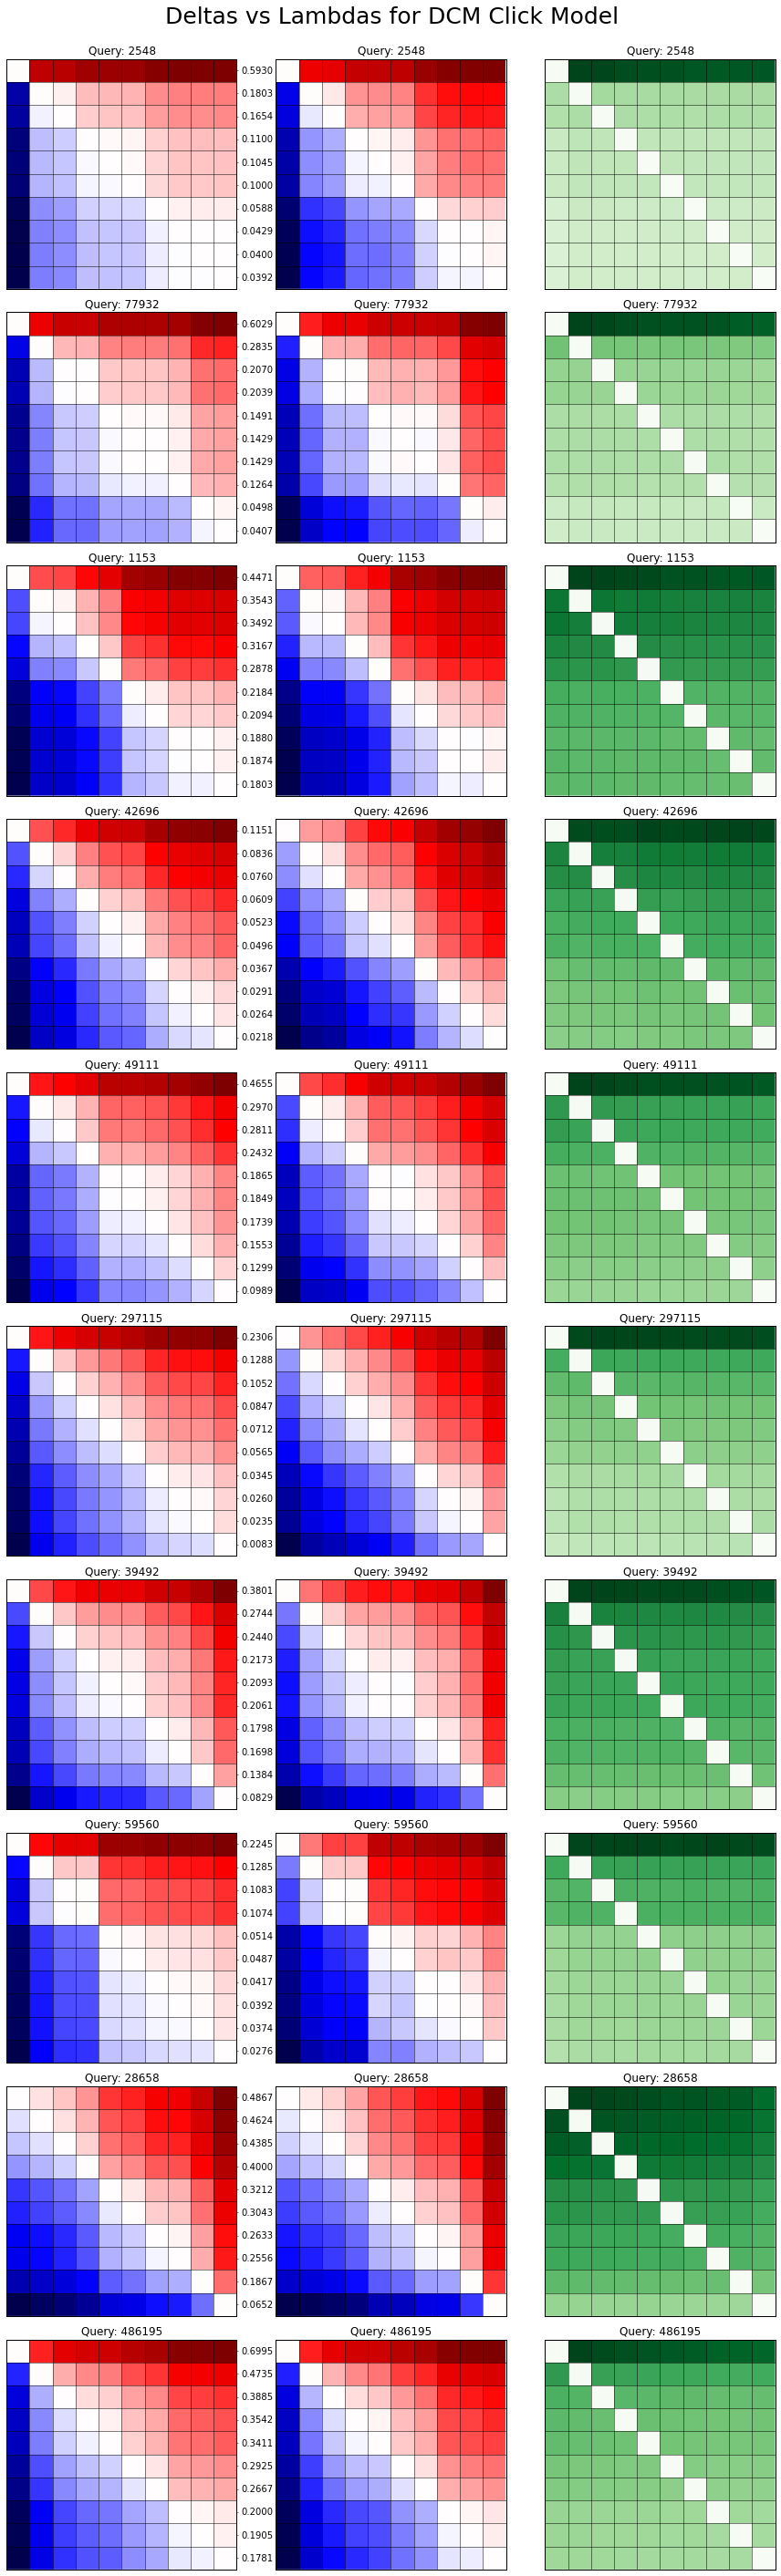

In [6]:
def show_click_model_lambdas_widget():
    def show_click_model_lambdas(click_model_type, n_impressions, lambdas_type):
        fig, axes = plt.subplots(10, 3, figsize=(12, 40))

        fig.suptitle('Deltas vs Lambdas for %s Click Model' % click_model_type,
                     fontsize=25)

        # Compute deltas (relevance differences) and plot them
        # into the 1st column of the heatmap plot.
        for i, query in enumerate(MQD[click_model_type].keys()):
            ax = axes[i, 0]

            ax.tick_params(axis='both', which='major', left='off',  top='off',
                           right='off', bottom='off', labelleft='off',  labeltop='off',
                           labelright='off', labelbottom='off')

            ax.tick_params(axis='both', which='minor', direction='out', left='off',
                           top='off', right='on', bottom='off', labelleft='off',
                           labeltop='off', labelright='on', labelbottom='off')

            ideal_ranking = MQD[click_model_type][query]['ideal_ranking']
            relevances = MQD[click_model_type][query]['relevances'][ideal_ranking]

            ax.imshow(relevances[:, None] - relevances[None, :], interpolation='none',
                      cmap=plt.get_cmap('seismic'), extent=[0, 10, 0, 10])

            ax.set_title('Query: %s' % query)
            ax.xaxis.set_major_locator(MultipleLocator(1.0))
            ax.yaxis.set_major_locator(MultipleLocator(1.0))
            ax.set_yticks(np.arange(len(relevances)) + 0.5, minor=True)
            ax.set_yticklabels(map(lambda s: '%.4f' % s, relevances[::-1]), minor=True)
            ax.grid(True, ls='-')

        # Plot lambdas and associated counts of impressions.
        for i, query in enumerate(MQD[click_model_type].keys()):
            ax = axes[i, 1]

            ax.tick_params(axis='both', which='both', left='off',  top='off',
                           right='off', bottom='off', labelleft='off',  labeltop='off',
                           labelright='off', labelbottom='off')

            ideal_ranking = MQD[click_model_type][query]['ideal_ranking']

            # Extract lambdas and counts...
            lambdas = MQD[click_model_type][query]['stats'][n_impressions][lambdas_type][0]
            lcounts = MQD[click_model_type][query]['stats'][n_impressions][
                                            lambdas_type.replace('_lambdas', '_counts')][0]

            # ... and reorder them according to the ideal ranking.
            lambdas = lambdas[ideal_ranking, :]
            lambdas = lambdas[:, ideal_ranking]
            lcounts = lcounts[ideal_ranking, :]
            lcounts = lcounts[:, ideal_ranking]

            ax.imshow(lambdas, interpolation='none', cmap=plt.get_cmap('seismic'),
                      extent=[0, 10, 0, 10])

            ax.set_title('Query: %s' % query)
            ax.xaxis.set_major_locator(MultipleLocator(1.0))
            ax.yaxis.set_major_locator(MultipleLocator(1.0))
            ax.grid(True, ls='-')

            # ===========================================================================
            # Same plot for the heatmap showing the counts of impressions
            # which were used to compute individual lambda_ij's.
            # ===========================================================================

            ax = axes[i, 2]

            ax.tick_params(axis='both', which='both', left='off',  top='off',
                           right='off', bottom='off', labelleft='off',  labeltop='off',
                           labelright='off', labelbottom='off')

            ax.imshow(lcounts, interpolation='none', cmap=plt.get_cmap('Greens'),
                      extent=[0, 10, 0, 10])

            ax.set_title('Query: %s' % query)
            ax.xaxis.set_major_locator(MultipleLocator(1.0))
            ax.yaxis.set_major_locator(MultipleLocator(1.0))
            ax.grid(True, ls='-')

        plt.tight_layout()
        plt.subplots_adjust(top=0.96) # Because of suptitle.
        plt.show(fig)
        
    n_impressions_options = sorted(MQD['DCM']['2548']['stats'].keys())[::-1]
    n_impressions_options = zip(map(str, n_impressions_options), n_impressions_options)
        
    cmdd = Dropdown(options=MQD.keys(), description='Click Model:')
    impdd = Dropdown(options=n_impressions_options, description='\0 \0 Impressions:')
    ltdd = Dropdown(options=[('Viewed', 'viewed_lambdas'), ('Total', 'total_lambdas')],
                    description='\0 \0 Lambas Type:')
    
    controls = HBox([cmdd, impdd, ltdd])

    backend = interactive(show_click_model_lambdas, click_model_type=cmdd, n_impressions=impdd,
                          lambdas_type=ltdd)

    controls.on_displayed(lambda _: show_click_model_lambdas(cmdd.value, impdd.value, ltdd.value))

    display(controls)

show_click_model_lambdas_widget()


# Probably Smallest Gap for $\lambda_{ij} \leftrightarrow \Delta_{ij}$

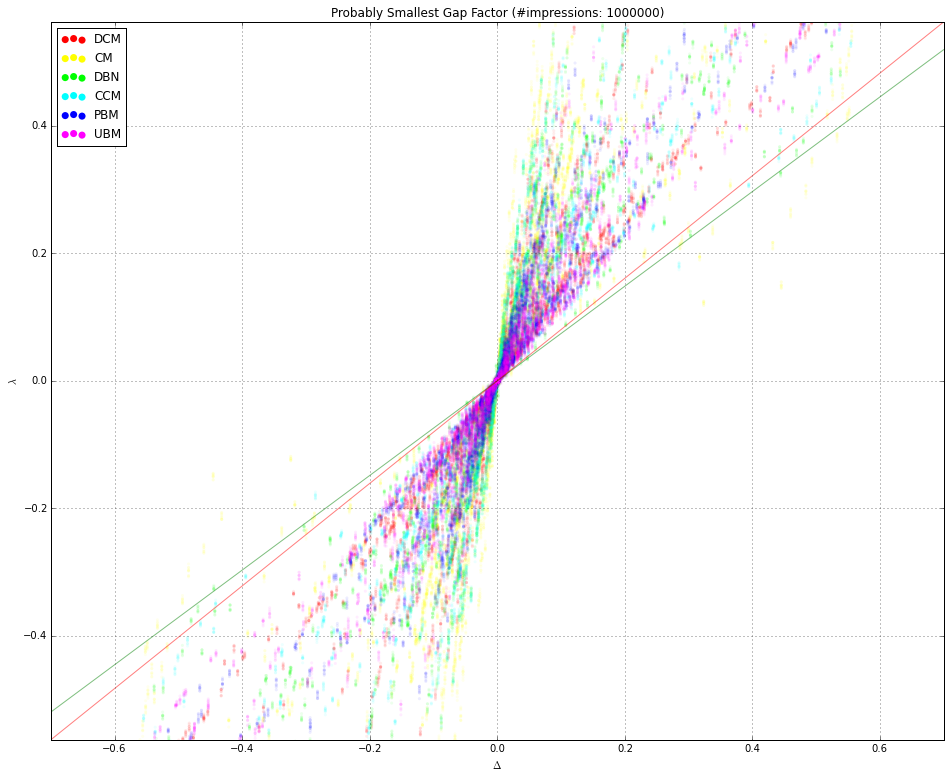

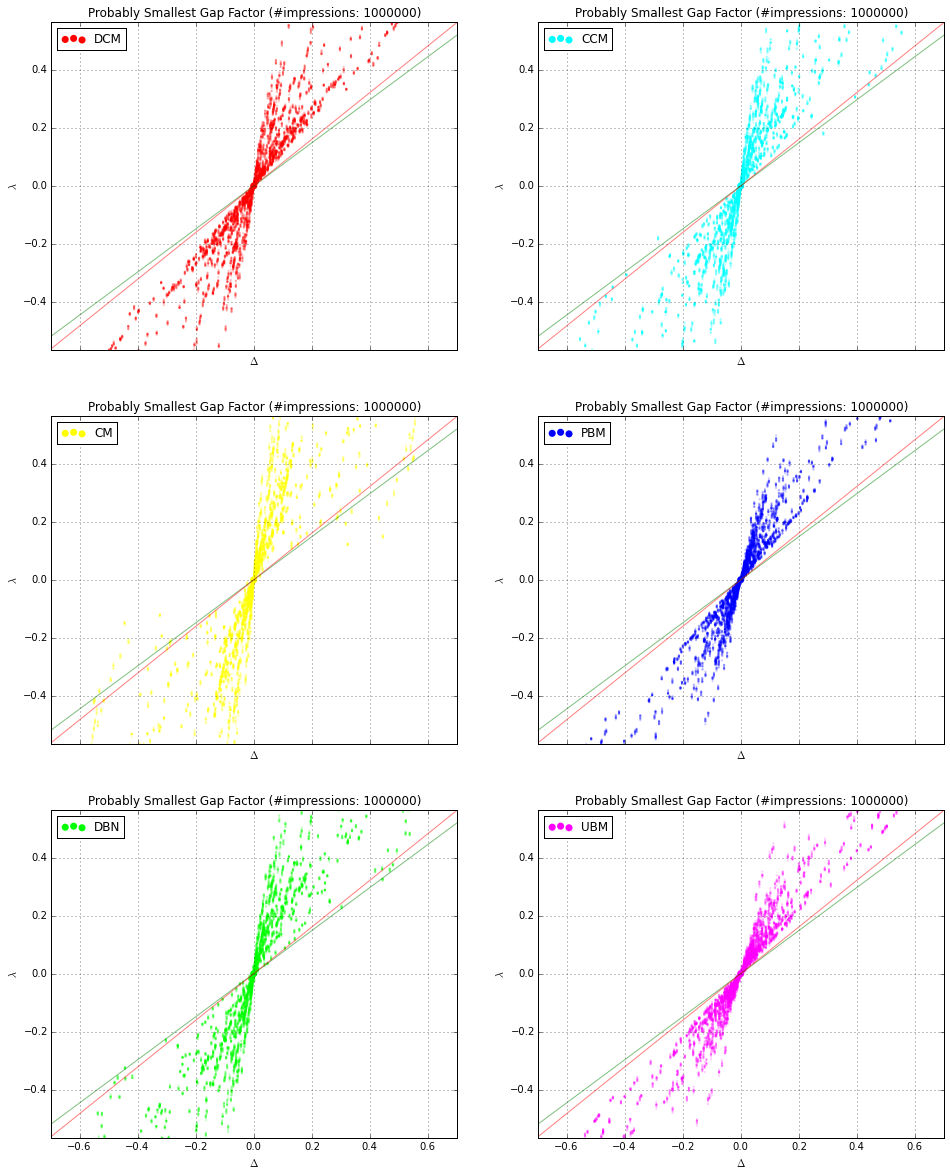

In [7]:
# Fished numbers :)
g1 = 0.741911843196 # 0.22796567480582483 # Green Line :- P(lambda < delta * g1) < 0.0033
r2 = 0.804044404376 # 0.79990317724734594 # Red Line :- P(lambda < delta * g1) < 0.01

def show_lambdas_vs_deltas_scatterplot_widget():
    def show_lambdas_vs_deltas_scatterplot(n_impressions, lambdas_type):
        cm_count = len(MQD)
        half_cm_count = cm_count / 2

        fig, ax = plt.subplots(1, 1, figsize=(16, 16), sharex=True)
        cm_fig, cm_axes = plt.subplots(half_cm_count, 2, figsize=(16, 20), sharex=True)

        for cm_i, click_model_name in enumerate(MQD):
            cm_ax = cm_axes[cm_i % half_cm_count, cm_i / half_cm_count]

            HSV = [cm_i * 1. / len(MQD),1,1]
            RGB = np.mat(hsv_to_rgb(HSV)).A

            ax.scatter(0, 0, s=50, c=RGB, edgecolor='none', label=click_model_name)
            cm_ax.scatter(0, 0, s=50, c=RGB, edgecolor='none', label=click_model_name)

            for query in MQD[click_model_name]:
                relevances = MQD[click_model_name][query]['relevances']
                deltas = relevances[:, None] - relevances[None, :]
                lambdas = MQD[click_model_name][query]['stats'][n_impressions][lambdas_type]

                y = lambdas.ravel()
                x = np.tile(deltas.ravel(), (lambdas.shape[0],))

                # nts_x_mask = (np.abs(x) > 1e-3)
                # x = x[nts_x_mask]
                # y = y[nts_x_mask]

                ax.scatter(x, y, s=10, c=np.tile(RGB,(x.shape[0],1)), edgecolor='none', alpha=0.07)
                cm_ax.scatter(x, y, s=5, c=np.tile(RGB,(x.shape[0],1)), edgecolor='none', alpha=0.2)
                
            x_lim = 0.7
            cm_ax.plot([-x_lim, x_lim], [-x_lim * g1, x_lim * g1], 'g-', alpha=0.5)
            cm_ax.plot([-x_lim, x_lim], [-x_lim * r2, x_lim * r2], 'r-', alpha=0.5)
            cm_ax.axis([-x_lim, x_lim,-x_lim * r2, x_lim * r2])
            
            cm_ax.set_title('Probably Smallest Gap Factor (#impressions: %d)' % n_impressions)
            cm_ax.set_ylabel(r'$\lambda$')
            cm_ax.set_xlabel(r'$\Delta$')
            cm_ax.set_aspect('equal')
            cm_ax.grid(True, axis='both', which='both')
            cm_ax.legend(loc='upper left')

        ax.plot([-x_lim, x_lim], [-x_lim * g1, x_lim * g1], 'g-', alpha=0.5)
        ax.plot([-x_lim, x_lim], [-x_lim * r2, x_lim * r2], 'r-', alpha=0.5)
        ax.axis([-x_lim, x_lim,-x_lim * r2, x_lim * r2])
        
        ax.set_title('Probably Smallest Gap Factor (#impressions: %d)' % n_impressions)
        ax.set_ylabel(r'$\lambda$')
        ax.set_xlabel(r'$\Delta$')
        ax.set_aspect('equal')
        
        plt.setp(ax.get_xticklabels(), visible=True)
        ax.grid(True, axis='both', which='both')
        ax.legend(loc='upper left')
    
    n_impressions_options = sorted(MQD['DCM']['2548']['stats'].keys())[::-1]
    n_impressions_options = zip(map(str, n_impressions_options), n_impressions_options)

    impdd = Dropdown(options=n_impressions_options, description='\0 \0 Impressions:')
    ltdd = Dropdown(options=[('Viewed', 'viewed_lambdas'), ('Total', 'total_lambdas')],
                    description='\0 \0 Lambas Type:')
    
    controls = HBox([impdd, ltdd])

    backend = interactive(show_lambdas_vs_deltas_scatterplot, n_impressions=impdd,
                          lambdas_type=ltdd)

    controls.on_displayed(lambda _: show_lambdas_vs_deltas_scatterplot(impdd.value, ltdd.value))

    display(controls)

show_lambdas_vs_deltas_scatterplot_widget()

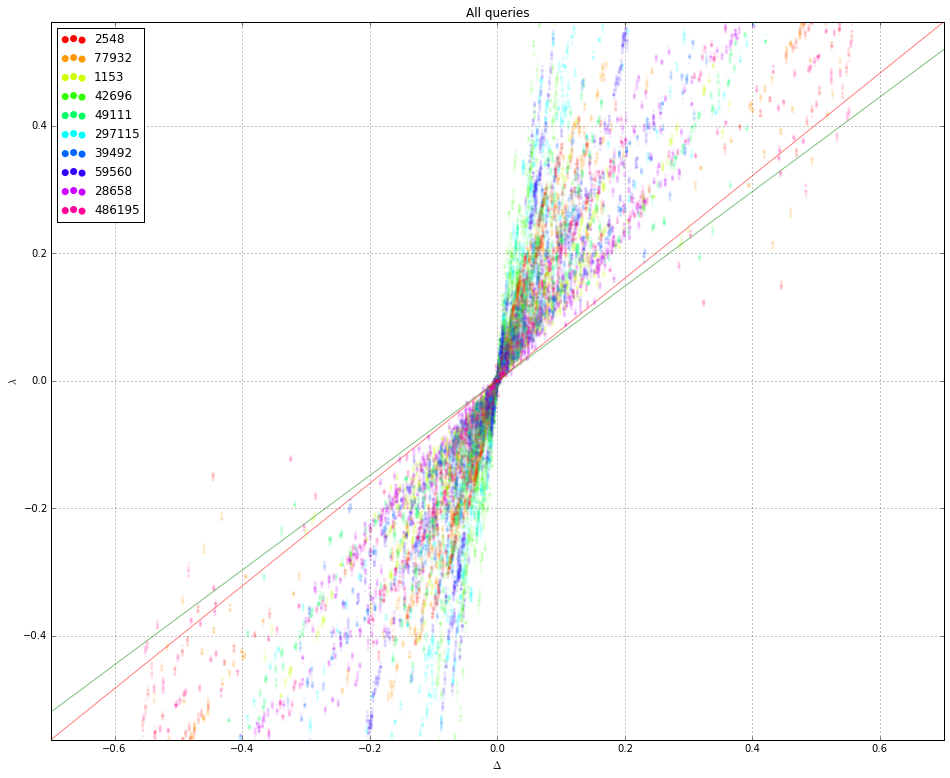

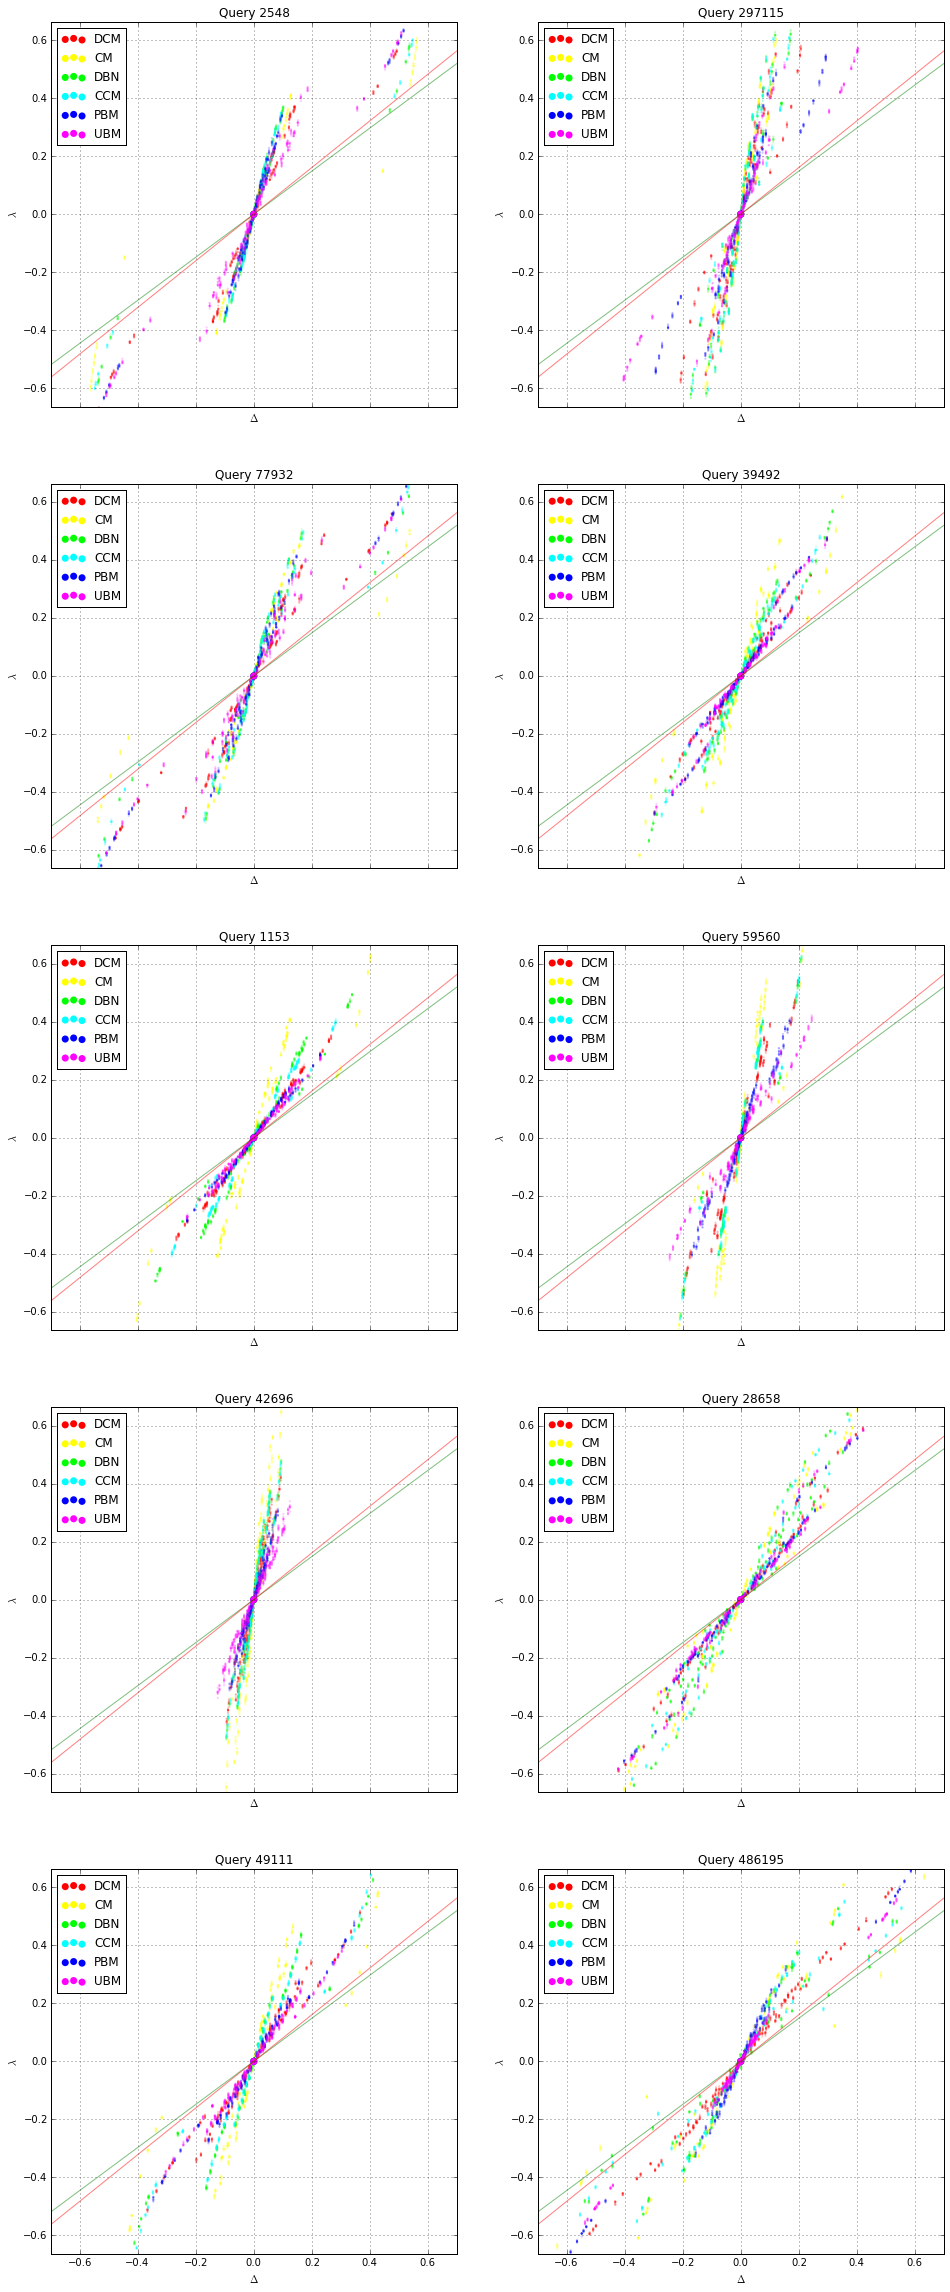

In [8]:
# Fished numbers :)
g1 = 0.741911843196 # 0.22796567480582483 # Green Line :- P(lambda < delta * g1) < 0.0033
r2 = 0.804044404376 # 0.79990317724734594 # Red Line :- P(lambda < delta * g1) < 0.01

def show_lambdas_vs_deltas_scatterplot_widget():
    def show_lambdas_vs_deltas_scatterplot(n_impressions, lambdas_type):
        cm_count = len(MQD)
        q_count = len(MQD[MQD.keys()[0]])
        half_q_count = q_count / 2
        
        fig, ax = plt.subplots(1, 1, figsize=(16, 16), sharex=True)
        q_fig, q_axes = plt.subplots(half_q_count, 2, figsize=(16, 40), sharex=True)
        
        for cm_i, click_model_name in enumerate(MQD):
            cmHSV = [cm_i * 1.0 / cm_count, 1, 1]
            cmRGB = np.mat(hsv_to_rgb(cmHSV)).A
            
            for q_i, query in enumerate(MQD[click_model_name]):
                q_ax = q_axes[q_i % half_q_count, q_i / half_q_count]
                
                HSV = [q_i * 1.0 / q_count, 1, 1]
                RGB = np.mat(hsv_to_rgb(HSV)).A
                
                if cm_i == 0:
                    ax.scatter(0, 0, s=50, c=RGB, edgecolor='none', label=query)
                q_ax.scatter(0, 0, s=50, c=cmRGB, edgecolor='none', label=click_model_name)
                
                relevances = MQD[click_model_name][query]['relevances']
                deltas = relevances[:, None] - relevances[None, :]
                lambdas = MQD[click_model_name][query]['stats'][n_impressions][lambdas_type]

                y = lambdas.ravel()
                x = np.tile(deltas.ravel(), (lambdas.shape[0],))

                # nts_x_mask = (np.abs(x) > 1e-3)
                # x = x[nts_x_mask]
                # y = y[nts_x_mask]

                ax.scatter(x, y, s=10, c=np.tile(RGB,(x.shape[0],1)), edgecolor='none', alpha=0.07)
                q_ax.scatter(x, y, s=5, c=np.tile(cmRGB,(x.shape[0],1)), edgecolor='none', alpha=0.2)
                
        x_lim = 0.7
        
        for q_i, query in enumerate(MQD[MQD.keys()[0]]):
            q_ax = q_axes[q_i % half_q_count, q_i / half_q_count]
            
            q_ax.plot([-x_lim, x_lim], [-x_lim * g1, x_lim * g1], 'g-', alpha=0.5)
            q_ax.plot([-x_lim, x_lim], [-x_lim * r2, x_lim * r2], 'r-', alpha=0.5)
            q_ax.axis([-x_lim, x_lim, -x_lim * r2, x_lim * r2])

            q_ax.set_title('Query ' + query)
            q_ax.set_ylabel(r'$\lambda$')
            q_ax.set_xlabel(r'$\Delta$')
            q_ax.set_aspect('equal')
            q_ax.grid(True, axis='both', which='both')
            q_ax.legend(loc='upper left')

        ax.plot([-x_lim, x_lim], [-x_lim * g1, x_lim * g1], 'g-', alpha=0.5)
        ax.plot([-x_lim, x_lim], [-x_lim * r2, x_lim * r2], 'r-', alpha=0.5)
        ax.axis([-x_lim, x_lim,-x_lim * r2, x_lim * r2])
        
        ax.set_title('All queries')
        ax.set_ylabel(r'$\lambda$')
        ax.set_xlabel(r'$\Delta$')
        ax.set_aspect('equal')
        plt.setp(ax.get_xticklabels(), visible=True)
        ax.grid(True, axis='both', which='both')
        ax.legend(loc='upper left')

    n_impressions_options = sorted(MQD['DCM']['2548']['stats'].keys())[::-1]
    n_impressions_options = zip(map(str, n_impressions_options), n_impressions_options)

    impdd = Dropdown(options=n_impressions_options, description='\0 \0 Impressions:')
    ltdd = Dropdown(options=[('Viewed', 'viewed_lambdas'), ('Total', 'total_lambdas')],
                    description='\0 \0 Lambas Type:')
    
    controls = HBox([impdd, ltdd])

    backend = interactive(show_lambdas_vs_deltas_scatterplot, n_impressions=impdd,
                          lambdas_type=ltdd)

    controls.on_displayed(lambda _: show_lambdas_vs_deltas_scatterplot(impdd.value, ltdd.value))

    display(controls)

show_lambdas_vs_deltas_scatterplot_widget()

# $\frac{\lambda}{\Delta}$ Histogram

## Not ignoring small $\Delta$ values

Green line is at 0.0
Red line is at 0.613612570208


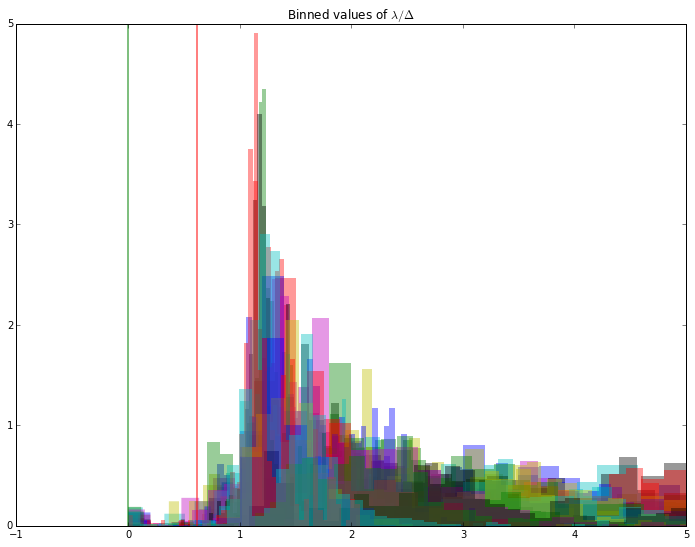

In [9]:
def show_lambdas_over_deltas_histogram_widget():
    def show_lambdas_over_deltas_histogram(n_impressions, lambdas_type, ratio_lower_bound):
        fig, ax = plt.subplots(figsize=(12, 9))

        all_ratios = []

        for click_model_name in MQD:
            for query in MQD[click_model_name]:
                relevances = MQD[click_model_name][query]['relevances']
                deltas = relevances[:, None] - relevances[None, :]
                lambdas = MQD[click_model_name][query]['stats'][n_impressions][lambdas_type]

                y = lambdas.ravel()
                x = np.tile(deltas.ravel(), (lambdas.shape[0],))

                nnz_x_mask = (np.abs(x) > ratio_lower_bound)
                
                x = x[nnz_x_mask]
                y = y[nnz_x_mask]

                ratio = np.clip(y / x, a_min=0, a_max=10)

                all_ratios.append(ratio)

                ax.hist(ratio, 50, edgecolor='none', normed=True, alpha=0.4)

        all_ratios = np.concatenate(all_ratios)
        all_ratios.sort()

        alpha = 0.0033
        ax.axvline(all_ratios[int(alpha * all_ratios.shape[0])], color='g', lw=2, alpha=0.5)
        print 'Green line is at',all_ratios[int(alpha * all_ratios.shape[0])]

        alpha = 0.01
        ax.axvline(all_ratios[int(alpha * all_ratios.shape[0])], color='r', lw=2, alpha=0.5)
        print 'Red line is at',all_ratios[int(alpha * all_ratios.shape[0])]

        ax.set_xlim([-1, 5])
        ax.set_ylim([0, 5])
        ax.set_title(r'Binned values of ${\lambda}/{\Delta}$')
        plt.show(fig)

    n_impressions_options = sorted(MQD['DCM']['2548']['stats'].keys())[::-1]
    n_impressions_options = zip(map(str, n_impressions_options), n_impressions_options)

    impdd = Dropdown(options=n_impressions_options, description='\0 \0 Impressions:')
    ltdd = Dropdown(options=[('Viewed', 'viewed_lambdas'), ('Total', 'total_lambdas')],
                    description='\0 \0 Lambas Type:')
    
    lambda_over_delta_options = [0., 0.001, 0.005, 0.01]
    lodt = Dropdown(options=zip(map(str, lambda_over_delta_options), lambda_over_delta_options),
                    description='\0 \0 Minimum $\lambda/\delta$')
    
    controls = HBox([impdd, ltdd, lodt])

    backend = interactive(show_lambdas_over_deltas_histogram, n_impressions=impdd,
                          lambdas_type=ltdd, ratio_lower_bound=lodt)

    controls.on_displayed(lambda _: show_lambdas_over_deltas_histogram(impdd.value,
                                                                       ltdd.value,
                                                                       lodt.value))

    display(controls)

show_lambdas_over_deltas_histogram_widget()